# 50 Years of Music Trends

## Objective
* Analyze lyrics from billboard top 100 songs over 50 years to identify trends
* Statement: Has the sentiments of popular lyrics changed over time?

## Hypothesis
* Ha = the sentiments of popular lyrics has become more negative over time
* Ho = no change in the sentiments of popular lyrics over time 

## Sources
* musixmatch source: https://developer.musixmatch.com/documentation/api-reference/track-lyrics-get <br/>
* musixmatch python: https://github.com/hudsonbrendon/python-musixmatch <br/>
* billboard python: https://github.com/guoguo12/billboard-charts<br/>

In [1]:
# Dependency library
import numpy as np
import pandas as pd
import random
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.stats import linregress

# API Calls
import billboard
from musixmatch import Musixmatch

# API Keys
from musixmatch_api import api_key

# Import and Initialize Sentiment Analyzer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [2]:
# Generate a (pseudo) random list of (almost all) dates in string format to fit musixmatch parameter

date_list = []
min_year = 1968
error_counter = 0

for i in range(50):
    try:
        # RANDOM date generation
        month_rand = str(random.randint(1,12))
        if len(month_rand) ==1:
            # PAD single digit numbers with a leading 0
            month_rand = month_rand.zfill(2)
            
        day_rand = str(random.randint(1,28))
        if len(day_rand) == 1:
            day_rand = day_rand.zfill(2)
        
        # STRINGIFY the result for the musixmatch parameter
        date_rand = str(f'{min_year}-{month_rand}-{day_rand}')
        
        # APPEND result to date_list
        date_list.append(date_rand)
        
        #INCREMENT the year
        min_year = min_year + 1
        
    except ValueError:
        error_counter = error_counter + 1

# VIEW date_list object
date_list

['1968-12-20',
 '1969-05-09',
 '1970-12-04',
 '1971-08-08',
 '1972-06-22',
 '1973-07-22',
 '1974-02-26',
 '1975-09-15',
 '1976-06-10',
 '1977-11-03',
 '1978-02-17',
 '1979-12-02',
 '1980-02-08',
 '1981-04-24',
 '1982-02-14',
 '1983-08-24',
 '1984-03-06',
 '1985-03-26',
 '1986-02-27',
 '1987-06-13',
 '1988-02-03',
 '1989-08-13',
 '1990-01-24',
 '1991-05-07',
 '1992-04-22',
 '1993-04-12',
 '1994-02-05',
 '1995-05-21',
 '1996-07-17',
 '1997-12-01',
 '1998-09-28',
 '1999-06-07',
 '2000-02-01',
 '2001-05-05',
 '2002-10-11',
 '2003-05-05',
 '2004-06-25',
 '2005-05-18',
 '2006-05-22',
 '2007-04-14',
 '2008-03-16',
 '2009-04-09',
 '2010-03-05',
 '2011-03-22',
 '2012-07-16',
 '2013-09-21',
 '2014-07-17',
 '2015-10-27',
 '2016-09-16',
 '2017-07-22']

In [3]:
# Return top 100 billboard songs for each date in random list generated above
# Note: Running this code takes approximately 2 minutes

billboard_list = 'hot-100'
col_names = ['Song','Artist','Date']
chart_df = pd.DataFrame(columns = col_names)

for date in date_list:
    chart = billboard.ChartData(billboard_list,date)
    for row in chart:
        # EMPTY the list placeholder used to create the dataframe
        chart_list = []
        # CLEAN and convert the billboard object
        chart_list.append(str(row).replace("'","",1))
        temp_df = pd.DataFrame(chart_list)
        temp_df = temp_df[0].str.split("' by ",expand=True)
        temp_df = temp_df.rename(columns={0:"Song",1:"Artist"})
        temp_df['Date'] = date
        
        # APPEND the temp_df in the current loop location to the chart_df
        chart_df = chart_df.append(temp_df)

# REMOVE duplicates and RESET index from the resulting dataframe        
chart_df = chart_df.drop_duplicates().reset_index(drop=True)

# VIEW dataframe head
print(len(chart_df))
chart_df.head()

5000


,Song,Artist,Date
0,I Heard It Through The Grapevine,Marvin Gaye,1968-12-20
1,Love Child,Diana Ross & The Supremes,1968-12-20
2,For Once In My Life,Stevie Wonder,1968-12-20
3,"Abraham, Martin And John",Dion,1968-12-20
4,Wichita Lineman,Glen Campbell,1968-12-20


In [4]:
# SPLIT the date values in the dataframe for plotting and analysis purposes

chart_df['Year'], chart_df['Month'], chart_df['Day'] = chart_df['Date'].str.split('-').str

# VIEW dataframe head
chart_df.head()

,Song,Artist,Date,Year,Month,Day
0,I Heard It Through The Grapevine,Marvin Gaye,1968-12-20,1968,12,20
1,Love Child,Diana Ross & The Supremes,1968-12-20,1968,12,20
2,For Once In My Life,Stevie Wonder,1968-12-20,1968,12,20
3,"Abraham, Martin And John",Dion,1968-12-20,1968,12,20
4,Wichita Lineman,Glen Campbell,1968-12-20,1968,12,20


In [5]:
# Retrieve lyrics from MusixMatch API based on song and artist in above dataframe
# Running this code takes approximately 5 - 7 minutes

musixmatch = Musixmatch(api_key)
lyrics_list = []
error_counter = 0

# LOOP through the data frame and use song title and artist name to search for lyrics in musixmatch
for x in range(len(chart_df)):
    
    # ERROR HANDLING in case a song queries returns 'null' from musixmatch
    try:
        # GRAB the lyrics based on location (iloc) in chart_df
        song_search = chart_df.iloc[x,0]
        artist_search = chart_df.iloc[x,1]
        lyrics = musixmatch.matcher_lyrics_get(q_artist=artist_search,
                                               q_track=song_search)['message']['body']['lyrics']['lyrics_body']
         
        # FORMATTING to truncate the nonsense at the end of the lyrics from MusixMatch
        song_length = len(lyrics)
        endpoint = len("******* This Lyrics is NOT for Commercial use *******\n(1409617829201)")
        lyrics = lyrics.replace("\n", " ")
        lyrics = str(lyrics[:song_length-endpoint])
        
        # APPEND lyrics to lyrics_list
        lyrics_list.append(lyrics)
        
    except:
        error_counter = error_counter + 1
        lyrics_list.append('MUSIXMATCH_NA')

# CREATE new column in chart_df
chart_df['Lyrics'] = lyrics_list

# VIEW dataframe head
chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,I Heard It Through The Grapevine,Marvin Gaye,1968-12-20,1968,12,20,Ooh I bet you're wonderin' how I knew 'Bout yo...
1,Love Child,Diana Ross & The Supremes,1968-12-20,1968,12,20,"Tenement slum Ooh, ooh, ooh... aaaahhh You th..."
2,For Once In My Life,Stevie Wonder,1968-12-20,1968,12,20,For once in my life I have someone who needs m...
3,"Abraham, Martin And John",Dion,1968-12-20,1968,12,20,Anybody here seen my old friend Abraham? Can y...
4,Wichita Lineman,Glen Campbell,1968-12-20,1968,12,20,I am a lineman for the county And I drive the ...


In [6]:
# REMOVE blanks and errors from the dataframe
clean_chart_df = chart_df[(chart_df['Lyrics'] != "MUSIXMATCH_NA") & (chart_df['Lyrics'] != "")].reset_index(drop=True)
# VIEW dataframe head
clean_chart_df.head()
# clean_chart_df.count()

,Song,Artist,Date,Year,Month,Day,Lyrics
0,I Heard It Through The Grapevine,Marvin Gaye,1968-12-20,1968,12,20,Ooh I bet you're wonderin' how I knew 'Bout yo...
1,Love Child,Diana Ross & The Supremes,1968-12-20,1968,12,20,"Tenement slum Ooh, ooh, ooh... aaaahhh You th..."
2,For Once In My Life,Stevie Wonder,1968-12-20,1968,12,20,For once in my life I have someone who needs m...
3,"Abraham, Martin And John",Dion,1968-12-20,1968,12,20,Anybody here seen my old friend Abraham? Can y...
4,Wichita Lineman,Glen Campbell,1968-12-20,1968,12,20,I am a lineman for the county And I drive the ...


In [7]:
# Vader Sentiment Analysis conducted on each song in the dataframe

# INITIALIZE a list to hold the sentiments
lyrics_sentiments = []

# ANALYZE the list
for y in range(len(clean_chart_df)):
    results = analyzer.polarity_scores(clean_chart_df.iloc[y,6])
    compound = results["compound"]
    pos = results["pos"]
    neu = results["neu"]
    neg = results["neg"]
    lyrics_sentiments.append({"Compound": compound,
                              "Positive": pos,
                              "Negative": neg,
                              "Neutral": neu})

# CREATE a dataframe of sentiment analysis that will be appended to the chart_df
lyrics_sentiments_df = pd.DataFrame(lyrics_sentiments)    
    
# APPEND new columns containing the sentiment analysis    
clean_chart_df['Compound'] = lyrics_sentiments_df['Compound']
clean_chart_df['Positive'] = lyrics_sentiments_df['Positive']
clean_chart_df['Negative'] = lyrics_sentiments_df['Negative']
clean_chart_df['Neutral'] = lyrics_sentiments_df['Neutral']

# SAVE to a .csv output
clean_chart_df.to_csv('billboard_analysis.csv')

# VIEW resulting dataframe head
clean_chart_df.head()

,Song,Artist,Date,Year,Month,Day,Lyrics,Compound,Positive,Negative,Neutral
0,I Heard It Through The Grapevine,Marvin Gaye,1968-12-20,1968,12,20,Ooh I bet you're wonderin' how I knew 'Bout yo...,0.7845,0.095,0.024,0.881
1,Love Child,Diana Ross & The Supremes,1968-12-20,1968,12,20,"Tenement slum Ooh, ooh, ooh... aaaahhh You th...",0.3322,0.186,0.183,0.631
2,For Once In My Life,Stevie Wonder,1968-12-20,1968,12,20,For once in my life I have someone who needs m...,0.9834,0.337,0.000,0.663
3,"Abraham, Martin And John",Dion,1968-12-20,1968,12,20,Anybody here seen my old friend Abraham? Can y...,0.8299,0.243,0.127,0.630
4,Wichita Lineman,Glen Campbell,1968-12-20,1968,12,20,I am a lineman for the county And I drive the ...,-0.6124,0.000,0.119,0.881


In [8]:
# Create the pandas dataframe group in order to calculate averages by year

chart_group = clean_chart_df.groupby(["Year"]).mean()
chart_group_df = pd.DataFrame(chart_group).reset_index(drop=False)
chart_group_df

,Year,Compound,Positive,Negative,Neutral
0,1968,0.546245,0.182909,0.065818,0.751273
1,1969,0.411727,0.154766,0.069143,0.776156
2,1970,0.439488,0.143234,0.061468,0.795286
3,1971,0.465723,0.159068,0.072781,0.768110
4,1972,0.319271,0.134466,0.069589,0.795986
5,1973,0.434140,0.159253,0.070973,0.769787
6,1974,0.516646,0.156033,0.055922,0.788033
7,1975,0.536561,0.187352,0.070915,0.741789
8,1976,0.387787,0.161303,0.066039,0.772645
9,1977,0.357534,0.150387,0.079275,0.770275


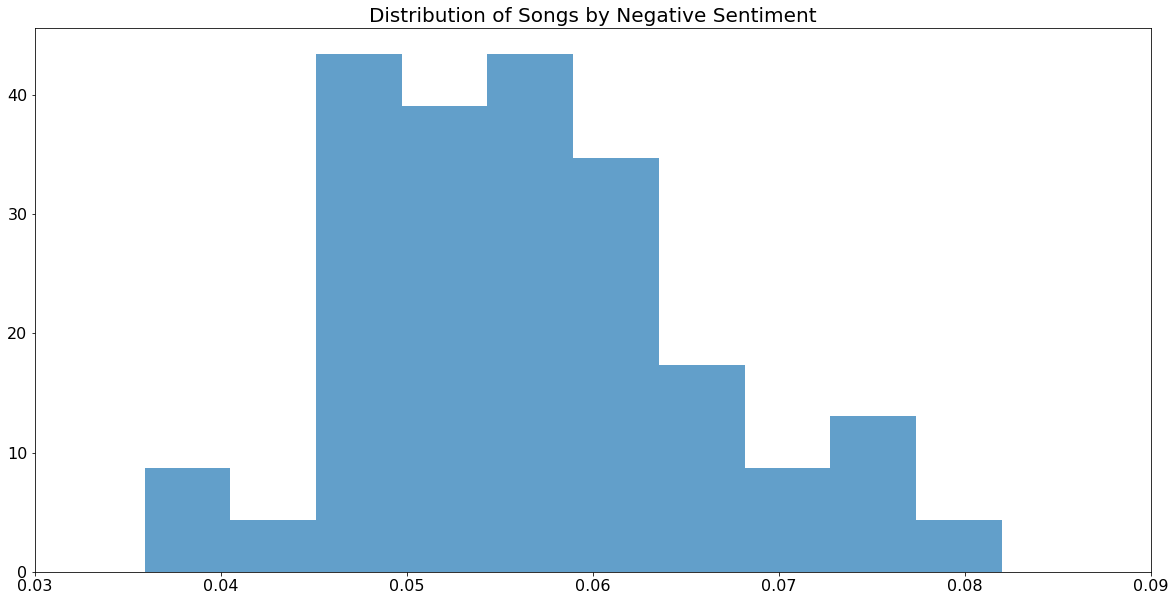

In [19]:
# TEST HISTOGRAM of negative sentiment results

#plt.figure()
#plt.subplot(figsize=(20,20))
plt.figure(figsize=(20,10))
plt.hist(chart_group_df['Negative'], 10, density=True, alpha=0.7, label="population1")
x,labels=plt.xticks()
labels=[0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11]
plt.xticks(x,labels,fontsize=16)
plt.xticks(label=labels)
plt.yticks(fontsize=16)
plt.title("Distribution of Songs by Negative Sentiment",fontsize=20)

plt.savefig("histogram.png")

In [10]:
# Create a local x-axis
x_axis = np.arange(1968,2018)
print(len(x_axis))
print(len(chart_group_df['Negative']))

50
50


r = 0.6915830181046972
r^2 = 0.47828707093080197
std err = 6.935438327451095e-05
p-value = 2.6825458206371704e-08
49% of the variation in the dependent variable (negative sentiment score) is accounted for by the variation in the independent variable (time in years). We feel comfortable using R^2, because the data is approximately normally distributed based on the shape of the histogram (slightly skewed right). Additionally, the p-value is 0+ which is < 0.05. Conclusion: We reject the null hypothesis (Ho) in favor of the alternative. These two variables are strongly related


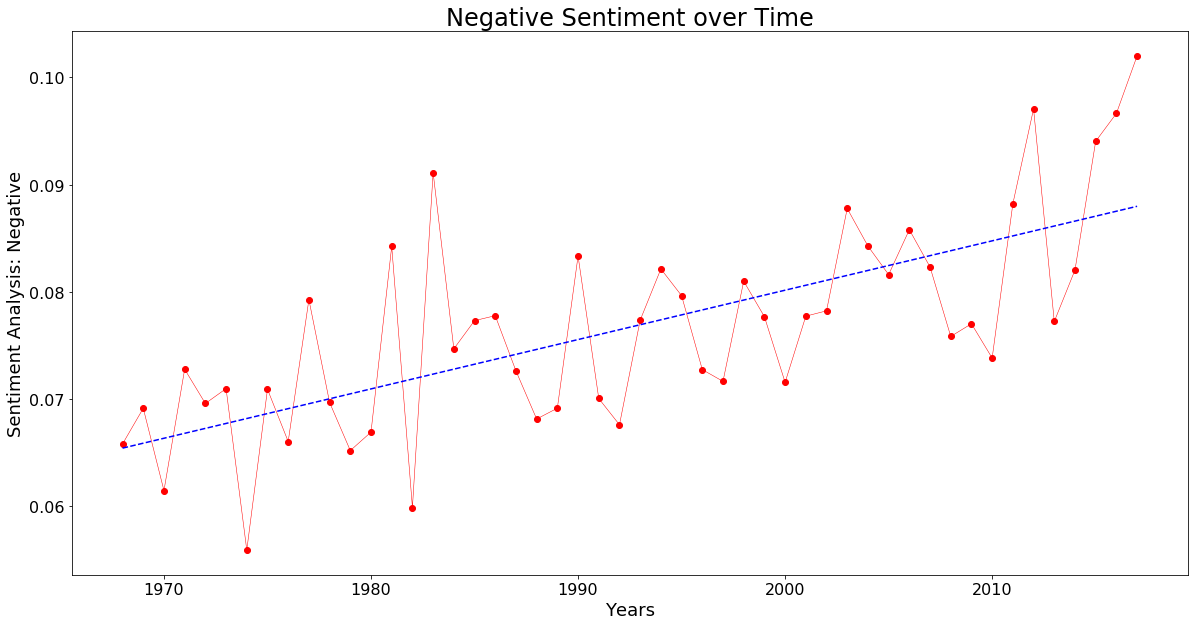

In [11]:
# Scatterplot of negative sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Negative'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Negative",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Negative Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Negative'], marker='o', color=('red'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("negative.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')
print('49% of the variation in the dependent variable (negative sentiment score) is accounted for by the variation \
in the independent variable (time in years). We feel comfortable using R^2, because the data is approximately \
normally distributed based on the shape of the histogram (slightly skewed right). Additionally, the p-value \
is 0+ which is < 0.05. \
Conclusion: We reject the null hypothesis (Ho) in favor of the alternative. These two variables are strongly related')

r = -0.7092852310177002
r^2 = 0.5030855389398324
std err = 0.00010893834883149997
p-value = 8.143077402214222e-09


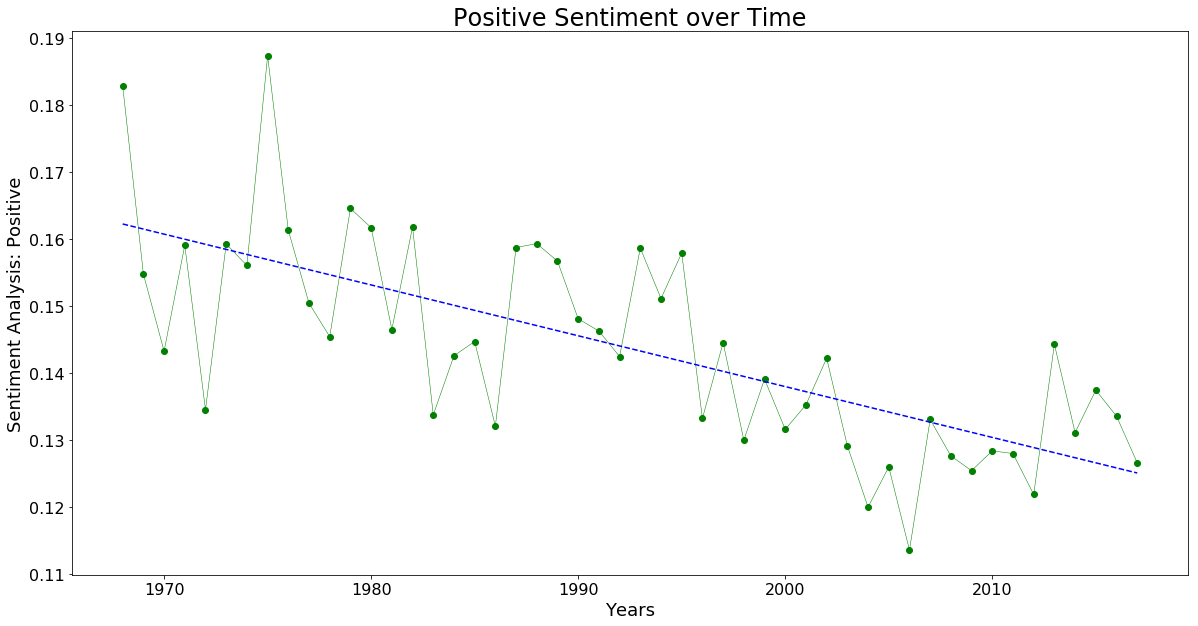

In [12]:
# Scatterplot of positive sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Positive'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Positive",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Positive Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Positive'], marker='o', color=('green'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("positive.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')

r = 0.3482081548585107
r^2 = 0.12124891910996857
std err = 0.00011615168574480349
p-value = 0.013211381609395707


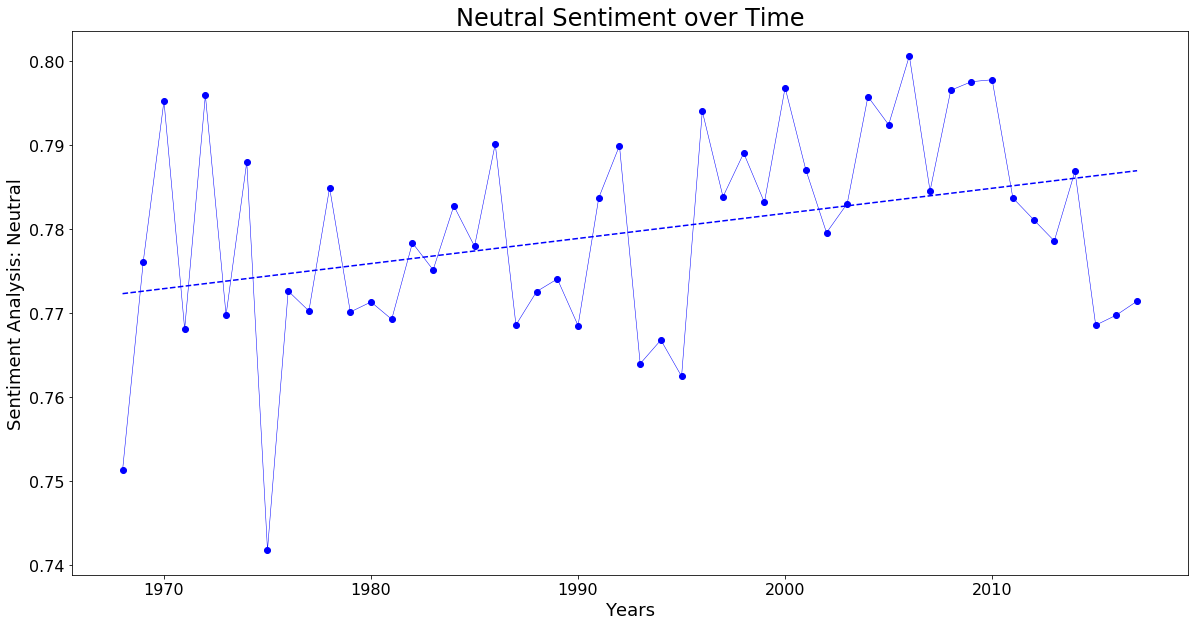

In [13]:
# Scatterplot of neutral sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Neutral'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Neutral",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Neutral Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Neutral'], marker='o', color=('blue'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("neutral.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')

r = -0.6468100972939544
r^2 = 0.4183633019614148
std err = 0.0006816996563424381
p-value = 3.877598614452497e-07


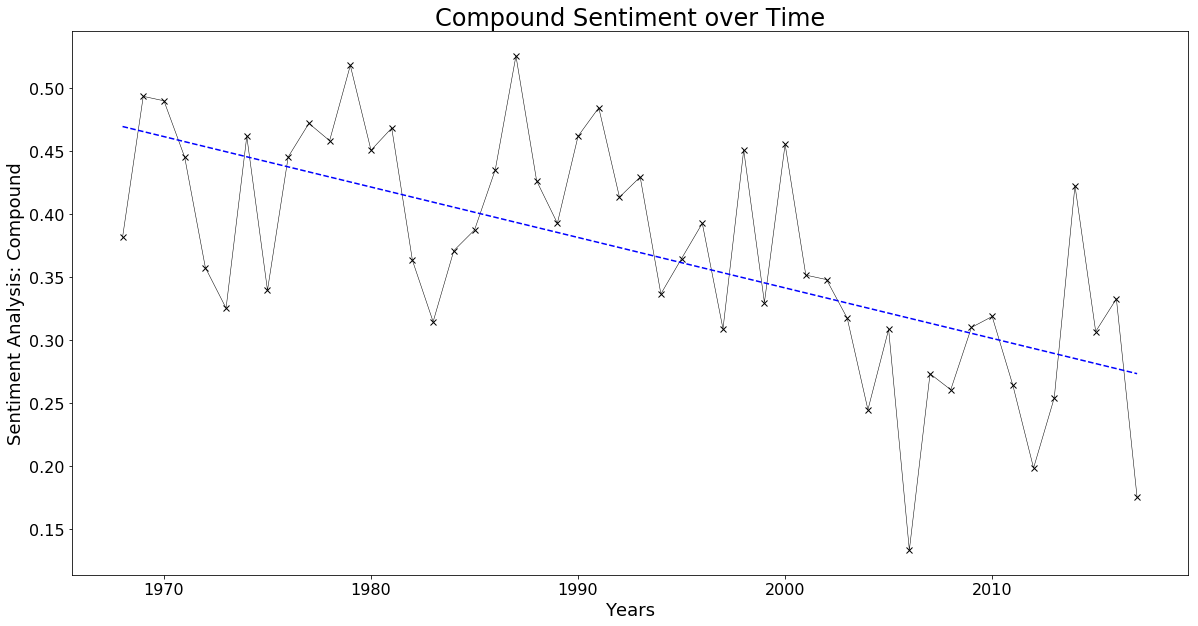

In [18]:
# Scatterplot of compound sentiment analysis

# Creates the regression line
(slope, intercept, r_value, p_value, std_err) = linregress(x_axis, chart_group_df['Compound'])
fit = slope * x_axis + intercept
r2 = r_value ** 2

# Sets up plot
fig, ax = plt.subplots(figsize=(20,10))
ax.set_xlabel("Years",fontsize=18)
ax.set_ylabel("Sentiment Analysis: Compound",fontsize=18)
ax.tick_params(labelsize=16)
ax.set_title(label="Compound Sentiment over Time",fontsize=24)

# Plots the data
ax.plot(x_axis, chart_group_df['Compound'], marker='x', color=('black'), linewidth=0.5)
ax.plot(x_axis, fit, 'b--')

plt.savefig("compound.png")

plt.show
print(f'r = {r_value}')
print(f'r^2 = {r2}')
print(f'std err = {std_err}')
print(f'p-value = {p_value}')